In [1]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, lognorm, expon, norm

In [2]:
df = pd.read_csv('data/BTCUSDT-trades-2025-05-16.csv')
df.columns = ['id', 'price', 'qty', 'quoteQty', 'time', 'isBuyerMaker', 'isBestMatch']
df

,id,price,qty,quoteQty,time,isBuyerMaker,isBestMatch
0,4912657966,103763.71,0.01301,1349.965867,1747353600187480,False,True
1,4912657967,103763.71,0.00095,98.575525,1747353600187480,False,True
2,4912657968,103763.71,0.00044,45.656032,1747353600187480,False,True
3,4912657969,103763.71,0.00045,46.693669,1747353600187480,False,True
4,4912657970,103763.71,0.00005,5.188186,1747353600187480,False,True
...,...,...,...,...,...,...,...
3237436,4915895402,103463.91,0.00048,49.662677,1747439997327912,False,True
3237437,4915895403,103463.91,0.00048,49.662677,1747439997573683,False,True
3237438,4915895404,103463.91,0.00676,699.416032,1747439997819634,False,True
3237439,4915895405,103463.90,0.00020,20.692780,1747439998489181,True,True


Start time: 2025-05-16 00:00:00.187480
End time: 2025-05-16 23:59:59.234885


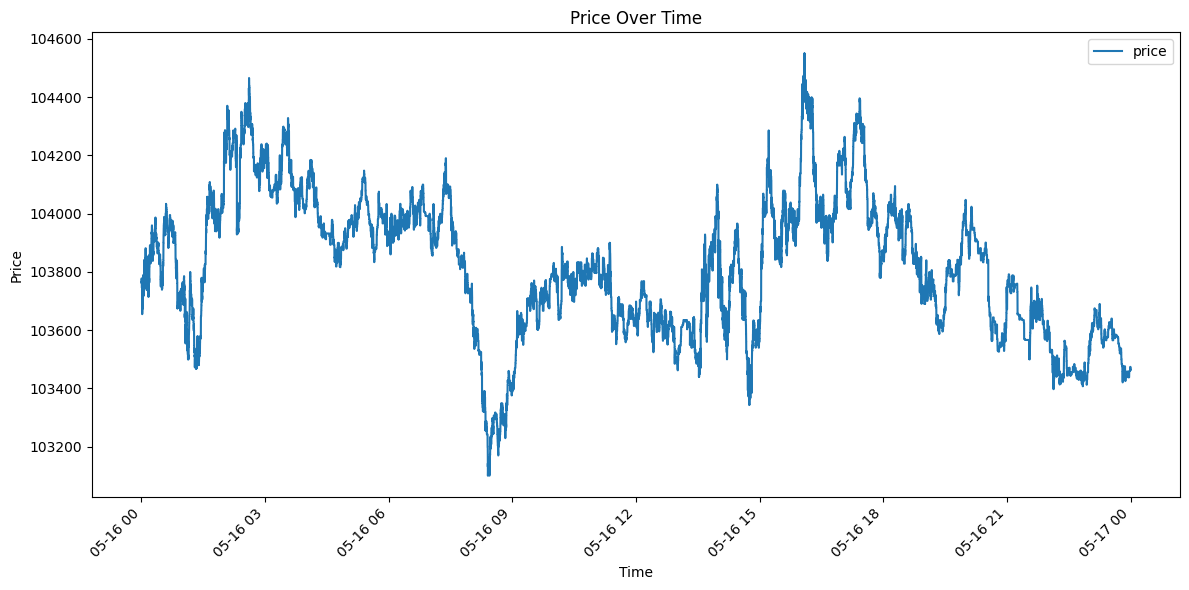

In [35]:
print(f"Start time: {df['time'].min()}")
print(f"End time: {df['time'].max()}")

plt.figure(figsize=(12, 6))  # optionally, improves spacing
plt.plot(df['time'], df['price'], label='price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Price Over Time')
plt.xticks(rotation=45, ha='right')  # rotate and align labels
plt.tight_layout()  # adjust layout to prevent label cutoff
plt.legend()
plt.show()

In [4]:
df['side'] = df['isBuyerMaker'].apply(lambda x: 'sell' if x else 'buy')

summary = df.groupby('side').agg({
    'id': 'count',         # number of trades
    'qty': 'sum',          # total BTC traded
    'quoteQty': 'sum'      # total USDT traded
}).rename(columns={'id': 'trade_count'})

summary['avg_price'] = summary['quoteQty'] / summary['qty']
summary

,trade_count,qty,quoteQty,avg_price
side,,,,
buy,1481450,7555.15795,7.848504e+08,103882.722395
sell,1755991,8128.72223,8.439820e+08,103827.141124


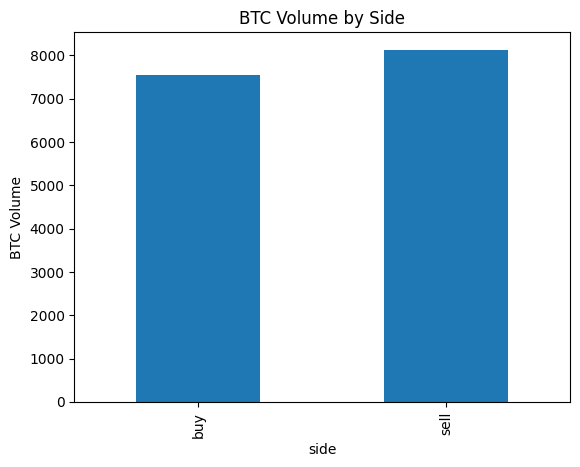

In [5]:
summary[['qty']].plot(kind='bar', title='BTC Volume by Side', legend=False)
plt.ylabel('BTC Volume')
plt.show()

In [6]:
# Convert UNIX ms timestamp to datetime
df['time'] = pd.to_datetime(df['time'], unit='us')

# Floor to minute
df['minute'] = df['time'].dt.floor('min')

# Count trades per minute
grouped = df.groupby('minute').size().reset_index(name='trades')

# Create interval labels
grouped['interval'] = grouped['minute'].astype(str) + ' – ' + (grouped['minute'] + timedelta(minutes=1)).astype(str)

# Reorder columns
result = grouped[['interval', 'trades']]

mean_trades = result['trades'].mean()
variance_trades = result['trades'].var()
print(f"Mean trades per minute: {mean_trades:.2f}")
print(f"Variance of trades per minute: {variance_trades:.2f}")

# Show the result
result.head(5)

Mean trades per minute: 2248.22
Variance of trades per minute: 2569565.44


,interval,trades
0,2025-05-16 00:00:00 – 2025-05-16 00:01:00,1593
1,2025-05-16 00:01:00 – 2025-05-16 00:02:00,3951
2,2025-05-16 00:02:00 – 2025-05-16 00:03:00,4213
3,2025-05-16 00:03:00 – 2025-05-16 00:04:00,4767
4,2025-05-16 00:04:00 – 2025-05-16 00:05:00,4574


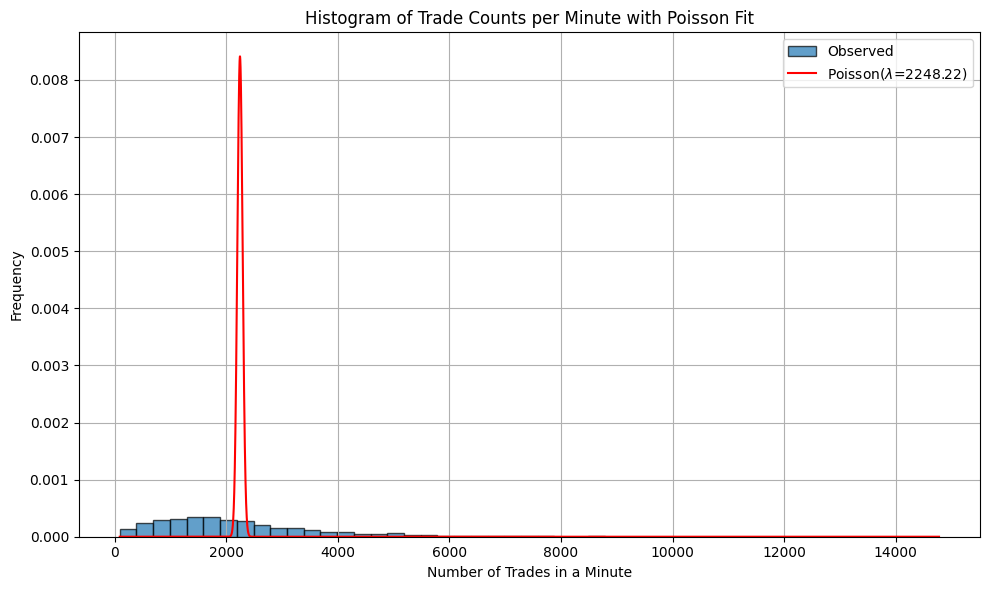

In [7]:
lambda_poisson = result['trades'].mean()

# Plot histogram
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(result['trades'], bins='auto', edgecolor='black', alpha=0.7, density=True, label='Observed')

# Create Poisson distribution
x = np.arange(min(result['trades']), max(result['trades']) + 1)
poisson_probs = poisson.pmf(x, mu=lambda_poisson)
poisson_scaled = poisson_probs

# Overlay Poisson curve
plt.plot(x, poisson_scaled, 'r-', label=f'Poisson($\\lambda$={lambda_poisson:.2f})')

# Labels
plt.xlabel('Number of Trades in a Minute')
plt.ylabel('Frequency')
plt.title('Histogram of Trade Counts per Minute with Poisson Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

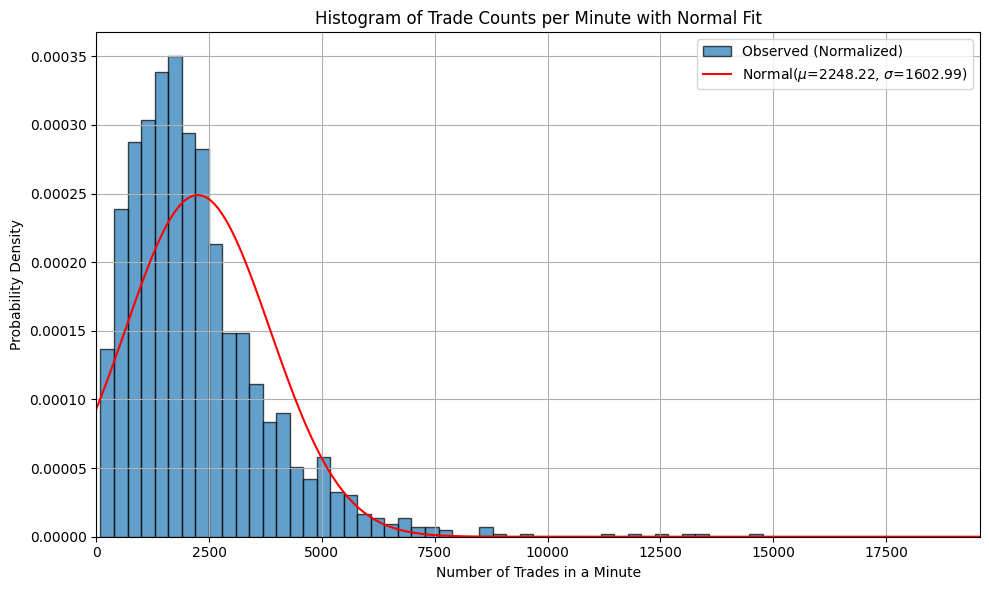

In [8]:
# Compute mean and standard deviation of the data
mu = result['trades'].mean()
sigma = result['trades'].std()

# Plot normalized histogram (as probability density)
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(result['trades'], bins='auto', edgecolor='black', alpha=0.7,
                           density=True, label='Observed (Normalized)')

# Generate x values for the normal distribution (starting from 1000)
x_start = 0
x_end = max(result['trades']) + sigma * 3  # extend to the right a bit
x = np.linspace(x_start, x_end, 500)
normal_pdf = norm.pdf(x, loc=mu, scale=sigma)

# Overlay Normal distribution
plt.plot(x, normal_pdf, 'r-', label=f'Normal($\\mu$={mu:.2f}, $\\sigma$={sigma:.2f})')

# Labels and limits
plt.xlabel('Number of Trades in a Minute')
plt.ylabel('Probability Density')
plt.title('Histogram of Trade Counts per Minute with Normal Fit')
plt.xlim(x_start, x_end)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

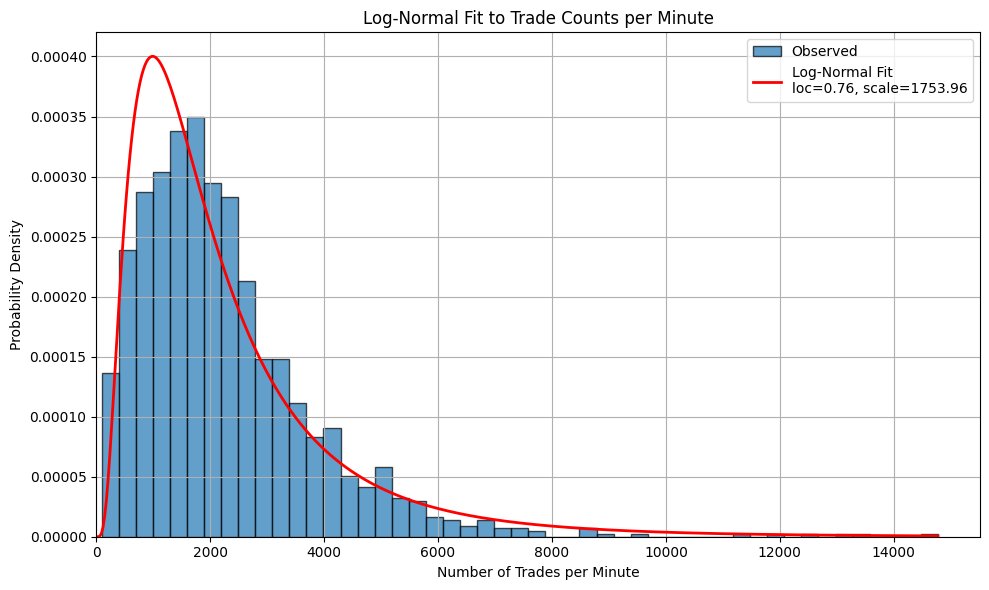

In [9]:
# Extract the trade counts
data = result['trades']

# Fit a log-normal distribution
shape, loc, scale = lognorm.fit(data, floc=0)

# Create x-values for plotting
x = np.linspace(0, max(data), 500)
lognorm_pdf = lognorm.pdf(x, shape, loc=loc, scale=scale)

# Plot histogram (normalized)
plt.figure(figsize=(10, 6))
plt.hist(data, bins='auto', density=True, alpha=0.7, edgecolor='black', label='Observed')

# Plot log-normal PDF
plt.plot(x, lognorm_pdf, 'r-', lw=2, label=f'Log-Normal Fit\nloc={shape:.2f}, scale={scale:.2f}')

# Labels
plt.xlabel('Number of Trades per Minute')
plt.ylabel('Probability Density')
plt.title('Log-Normal Fit to Trade Counts per Minute')
plt.xlim(left=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


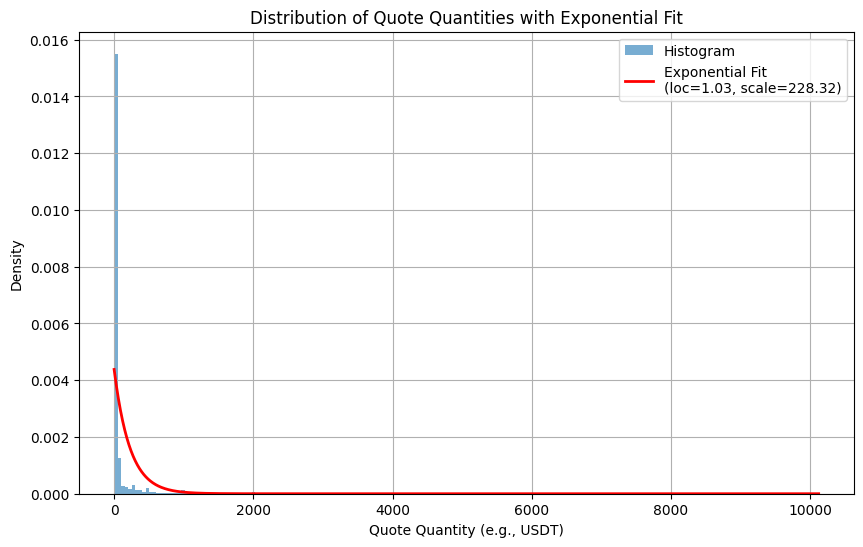

In [10]:
# Convert to numeric and drop NaNs
df['quoteQty'] = pd.to_numeric(df['quoteQty'], errors='coerce')
df = df.dropna(subset=['quoteQty'])

# Filter extreme values for readability (optional)
df_filtered = df[df['quoteQty'] < df['quoteQty'].quantile(0.99)]

# Fit exponential distribution (loc should be close to 0)
loc, scale = expon.fit(df_filtered['quoteQty'])

# Prepare data for PDF
x = np.linspace(df_filtered['quoteQty'].min(), df_filtered['quoteQty'].max(), 1000)
pdf = expon.pdf(x, loc=loc, scale=scale)

# Plot
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['quoteQty'], bins=200, density=True, alpha=0.6, label='Histogram')
plt.plot(x, pdf, 'r-', lw=2, label=f'Exponential Fit\n(loc={loc:.2f}, scale={scale:.2f})')
plt.xlabel('Quote Quantity (e.g., USDT)')
plt.ylabel('Density')
plt.title('Distribution of Quote Quantities with Exponential Fit')
plt.legend()
plt.grid(True)
plt.show()

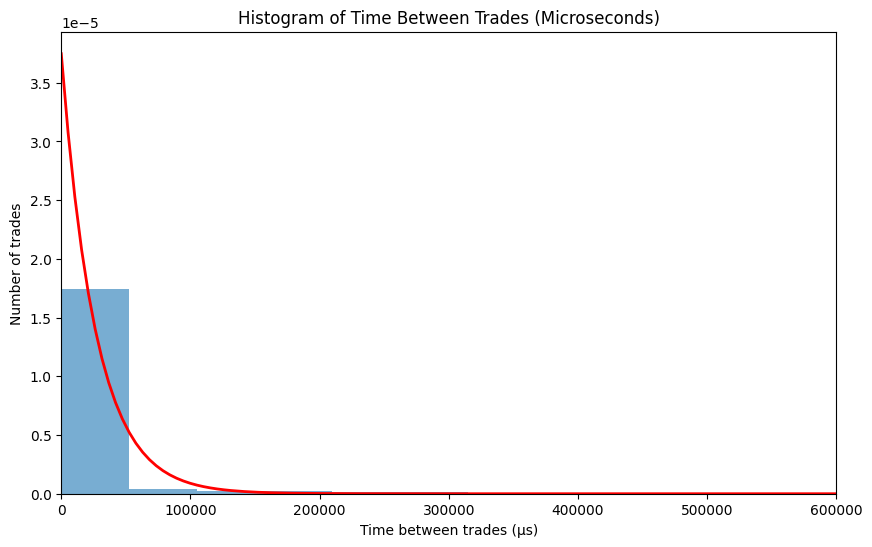

In [33]:
# Compute time difference in microseconds
df['time_diff'] = df['time'].diff().dt.total_seconds() * 1_000_000  # microseconds

# Drop NaNs (first row will be NaN)
time_diffs = df['time_diff'].dropna()

# Fit exponential distribution (loc should be close to 0)
loc, scale = expon.fit(time_diffs)

# Prepare data for PDF
x = np.linspace(time_diffs.min(), time_diffs.max(), 1000)
pdf = expon.pdf(x, loc=loc, scale=scale)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.plot(x, pdf, 'r-', lw=2, label=f'Exponential Fit\n(loc={loc:.2f}, scale={scale:.2f})')
plt.hist(time_diffs, bins=100, density=True, alpha=0.6, label='Histogram')
plt.xlabel("Time between trades (µs)")
plt.ylabel("Number of trades")
plt.xlim(0, .6 * 1_000_000)
plt.title("Histogram of Time Between Trades (Microseconds)")
plt.show()